<a href="https://colab.research.google.com/github/chaitsugale/Style-Transfer-using-CycleGAN/blob/main/Style_Transfer_MR1_T1_T2_Cyclic_GAN_Capstone_Project_Chaitanya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer Using Cyclic GAN Capstone Project

### By: Chaitanya Ugale

**Background** :

Misdiagnosis in the medical field is a very serious issue but it’s also uncomfortably common to occur. Imaging procedures in the medical field requires an expert radiologist’s opinion since interpreting them is not a simple binary process ( Normal or Abnormal). Even so, one radiologist may see something that another does not. This can lead to conflicting reports and make it difficult to effectively recommend treatment options to the patient.

One of the complicated tasks in medical imaging is to diagnose MRI(Magnetic Resonance Imaging). Sometimes to interpret the scan, the radiologist needs different variations of the imaging which can drastically enhance the accuracy of diagnosis by providing practitioners with a more comprehensive understanding.

But to have access to different imaging is difficult and expensive. With the help of deep learning, we can use style transfer to generate artificial MRI images of different contrast levels from existing MRI scans. This will help to provide a better diagnosis with the help of an additional image.

**Problem Statement :**

To build a Generative adversarial model(modified U-Net) which can generate artificial MRI images of different contrast levels from existing MRI scans.

### Importing Packages

In [1]:
# Importing warning package
import warnings
warnings.filterwarnings('ignore')

# Importing all the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import imageio
import glob
import os
import cv2
import pathlib

# importinf tensorflow libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Sequential,optimizers,metrics,Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Activation,Flatten,Conv2D,Conv2DTranspose
from keras.utils.vis_utils import plot_model

In [2]:
#loading the package for google drive

from google.colab import drive

#mounting content from google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#unzipping the file

!unrar x "gdrive/MyDrive/MRI+T1_T2+Dataset.RAR" "/content/gdrive/MyDrive/"

#!unzip gdrive/MyDrive/MRI+T1_T2+Dataset -d '/content/gdrive/MyDrive/'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from gdrive/MyDrive/MRI+T1_T2+Dataset.RAR

Creating    /content/gdrive/MyDrive/Tr1                               OK
Extracting  /content/gdrive/MyDrive/Tr1/.DS_Store                          0%  OK 
Creating    /content/gdrive/MyDrive/Tr1/TrainT1                       OK
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #10.png              1%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #11.png              2%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #12.png              3%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #13.png              4%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #14.png              5%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #15.png              6%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #16.png              7% 

Counts of File

In [4]:
#Defining the path of data

#for tr1
#tr1_data = pathlib.Path('/content/gdrive/MyDrive/Tr1/TrainT1')

#for tr2
#tr2_data = pathlib.Path('/content/gdrive/MyDrive/Tr2/TrainT2')

base_dir = pathlib.Path("/content/gdrive/My Drive")
os.chdir(base_dir)

tr1_data = pathlib.Path(str(base_dir) + "/Tr1/TrainT1")
tr2_data = pathlib.Path(str(base_dir) + "/Tr2/TrainT2")

print("Path for T1 data :\n", tr1_data)
print("Path for T2 data :\n", tr2_data)

Path for T1 data :
 /content/gdrive/My Drive/Tr1/TrainT1
Path for T2 data :
 /content/gdrive/My Drive/Tr2/TrainT2


## Step 1 : Data Understanding

In [5]:
# Checking the image count 

image_count_tr1 = len(list(tr1_data.glob('*.png')))

image_count_tr2 = len(list(tr2_data.glob('*.png')))

print('No. of image in TR1 : ',image_count_tr1)

print('No. of image in TR2 : ',image_count_tr2)

No. of image in TR1 :  43
No. of image in TR2 :  46


In [6]:
# sample to check the image size

mr1_sample = cv2.imread('/content/gdrive/MyDrive/Tr1/TrainT1/Image #34.png')

mr1_sample.shape

(217, 181, 3)

In [7]:
# The input shape for image should be (256, 256) so we are setting the image size

image_height = 217
image_width = 181

In [8]:
# setting up default batch size

mr1_batch_size = 64

### Loading Image

In [9]:
t1_image = image_dataset_from_directory(tr1_data,seed=123,shuffle = True,labels = None,image_size = (image_height,image_width),batch_size = mr1_batch_size )

Found 43 files belonging to 1 classes.


In [10]:
t2_image = image_dataset_from_directory(tr2_data,seed=123,shuffle = True,labels = None,image_size = (image_height,image_width),batch_size = mr1_batch_size )

Found 46 files belonging to 1 classes.


### Data Visualization

TR1 IMAGE


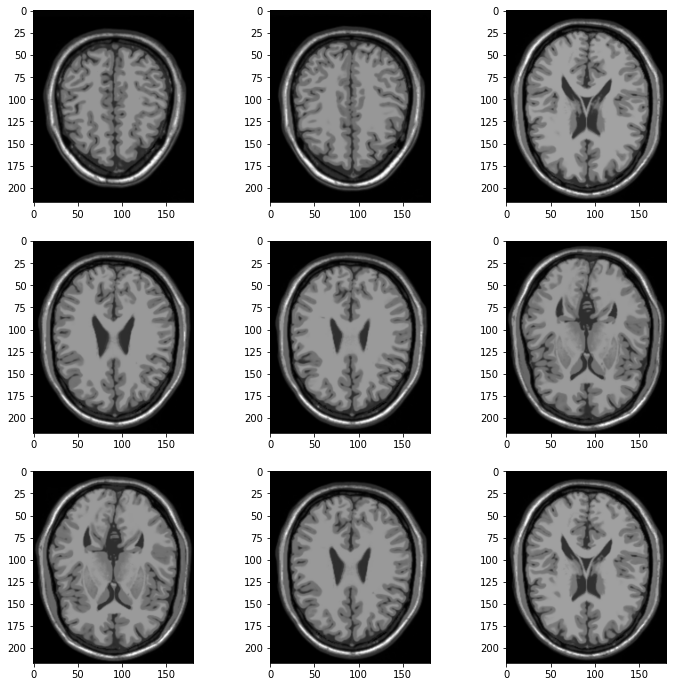

In [11]:
plt.figure(figsize=(12,12))
  
print("TR1 IMAGE")

for images in t1_image.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))

TR2 IMAGE


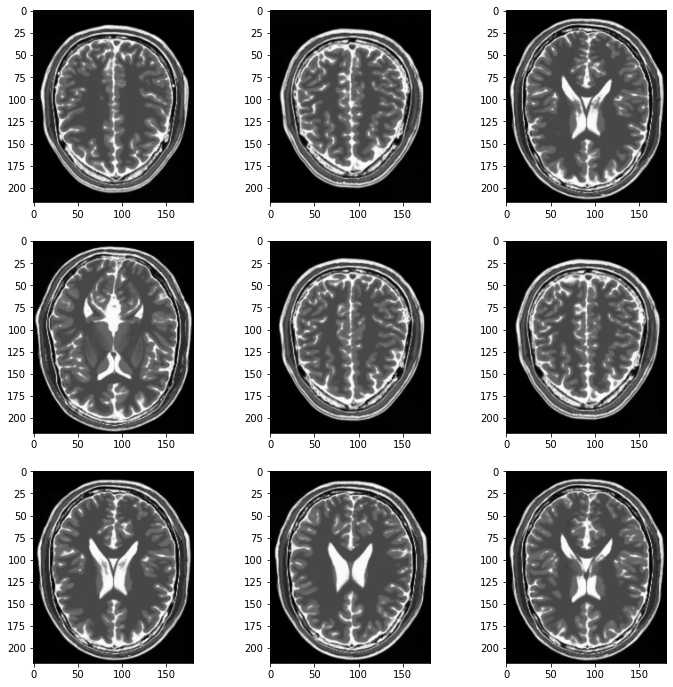

In [12]:
plt.figure(figsize=(12,12))
  
print("TR2 IMAGE")

for images_1 in t2_image.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_1[i].numpy().astype('uint8'))

In [13]:
# checking the range of value of pixel making up the image in T1 data

image_batch = next(iter(t1_image))

first_image = image_batch[0]

print('Pixel Value Range of T1 Image is from ',np.min(first_image),' to ',np.max(first_image))

Pixel Value Range of T1 Image is from  0.0  to  255.0


In [14]:
# checking the range of value of pixel making up the image in T2 data

image_batch= next(iter(t2_image))

first_image = image_batch[0]

print('Pixel Value Range of T2 Image is from ',np.min(first_image),' to ',np.max(first_image))

Pixel Value Range of T2 Image is from  0.0  to  255.0


## Step 2 : Data Preprocessing




### A. Data Normalization

In [15]:
# Defining normalization layer

normalization_layer  =  layers.experimental.preprocessing.Rescaling(scale = 1./127.5, offset =-1.0)

In [16]:
# Normalizing T1 Images

normalize_t1 = t1_image.map(lambda x: (normalization_layer(x)))

image_batch1 = next(iter(normalize_t1))

first_image = image_batch1[0]

print('After Normalization for T1 : ')

print('Minimum : ',np.min(first_image),' Maximum : ',np.max(first_image))

After Normalization for T1 : 
Minimum :  -1.0  Maximum :  1.0


In [17]:
# checking shape of batch

image_t1_batch = next(iter(normalize_t1))

image_t1_batch.shape

TensorShape([43, 217, 181, 3])

TR1 IMAGE


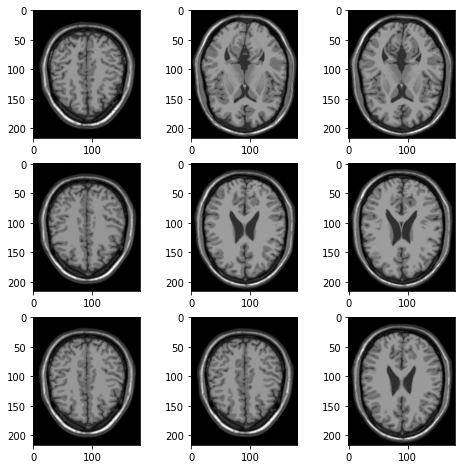

In [18]:
# visualizing data for T1 dataset after normalization

plt.figure(figsize=(8,8))
  
print("TR1 IMAGE")

for images_2 in normalize_t1.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images_2[i]*127.5+127.5).numpy().astype('uint8'))



In [19]:
normalize_t2 = t2_image.map(lambda x: (normalization_layer(x)))

image_batch_2 = next(iter(normalize_t2))

first_image = image_batch_2[0]

print('After Normalization : ')

print('Minimum : ',np.min(first_image),' Maximum : ',np.max(first_image))

After Normalization : 
Minimum :  -1.0  Maximum :  1.0


In [20]:
image_t2_batch = next(iter(normalize_t2))

image_t2_batch.shape

TensorShape([46, 217, 181, 3])

TR2 IMAGE


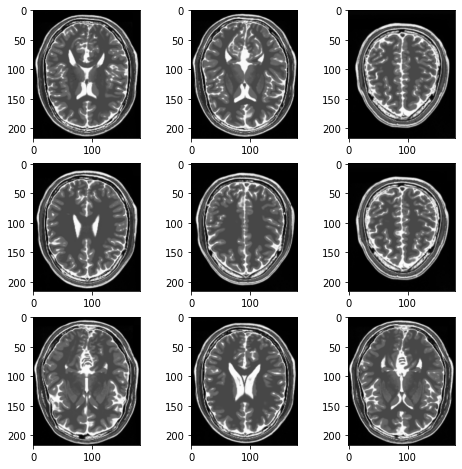

In [21]:
plt.figure(figsize=(8,8))
  
print("TR2 IMAGE")

for images_3 in normalize_t2.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images_3[i]* 127.5 + 127.5).numpy().astype('uint8'))

In [22]:
# Resizing data to (128,128)

mr1_resize_layer = layers.experimental.preprocessing.Resizing(128, 128, interpolation='bilinear')

In [23]:
image_t1_resized = normalize_t1.map(lambda x:(mr1_resize_layer(x)))

image_batch = next(iter(image_t1_resized))

first_image = image_batch[0]

print('After resizing : ',first_image.shape)

After resizing :  (128, 128, 3)


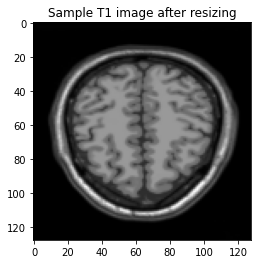

In [24]:
# plotting image for tr1

plt.imshow((first_image * 127.5 + 127.5).numpy().astype("uint8"))   # Reversing the scaling for visualization
plt.title("Sample T1 image after resizing")
plt.show()

In [25]:
# for tr2

image_t2_resized = normalize_t2.map(lambda x:(mr1_resize_layer(x)))

image_batch = next(iter(image_t2_resized))

first_image = image_batch[0]

print('After resizing : ',first_image.shape)

After resizing :  (128, 128, 3)


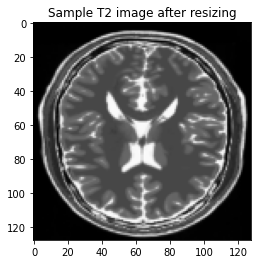

In [26]:
plt.imshow((first_image * 127.5 + 127.5).numpy().astype("uint8"))   # Reversing the scaling for visualization
plt.title("Sample T2 image after resizing")
plt.show()

In [27]:
# Reshaping the image

mr1_reshape_layer = layers.Reshape((128,128,1))

In [28]:
image_t1_reshape = image_t1_resized.map(lambda x: mr1_reshape_layer(x[:,:,:,0]))

image_batch = next(iter(image_t1_reshape))
print(image_batch.shape)
first_image = image_batch[0]
print('Shape of reshaped images: ',first_image.shape)

(43, 128, 128, 1)
Shape of reshaped images:  (128, 128, 1)


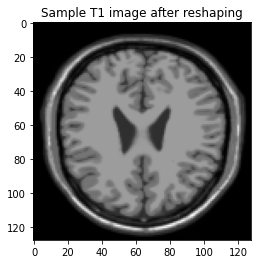

In [29]:
plt.imshow(first_image.numpy()[:, :, 0], cmap='gray')
plt.title("Sample T1 image after reshaping")
plt.show()

In [30]:
# for t2

image_t2_reshape = image_t2_resized.map(lambda x: mr1_reshape_layer(x[:,:,:,0]))

image_batch = next(iter(image_t2_reshape))
print(image_batch.shape)
first_image = image_batch[0]
print('Shape of reshaped images: ',first_image.shape)



(46, 128, 128, 1)
Shape of reshaped images:  (128, 128, 1)


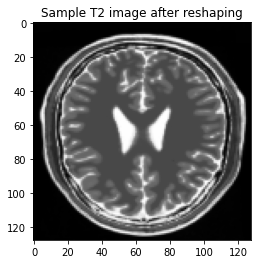

In [31]:
plt.imshow(first_image.numpy()[:, :, 0], cmap='gray')
plt.title("Sample T2 image after reshaping")
plt.show()

### Batch and Reshuffle Data

In [32]:
#setting buffer size

mr1_buffer_size = 64

In [33]:
t1_image_data = image_t1_reshape.shuffle(mr1_buffer_size)

t2_image_data = image_t2_reshape.shuffle(mr1_buffer_size)

In [34]:
image_batch = next(iter(t1_image_data))

print("T1 image batch shape : ",image_batch.shape)

first_image = image_batch[0]

print('shape of image : ',first_image.shape)



T1 image batch shape :  (43, 128, 128, 1)
shape of image :  (128, 128, 1)


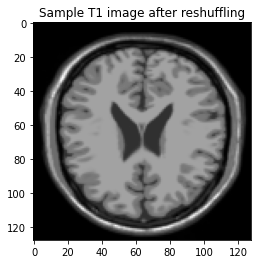

In [35]:
plt.imshow(first_image.numpy()[:, :, 0], cmap='gray')
plt.title("Sample T1 image after reshuffling")
plt.show()

In [36]:
image_batch = next(iter(t2_image_data))

print("T1 image batch shape : ",image_batch.shape)

first_image = image_batch[0]

print('shape of image : ',first_image.shape)



T1 image batch shape :  (46, 128, 128, 1)
shape of image :  (128, 128, 1)


T2 image sample after reshuffle


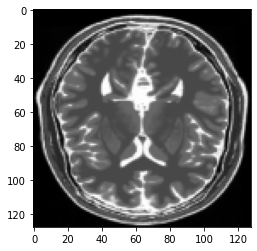

In [37]:
plt.imshow(first_image.numpy()[:,:,0], cmap = 'gray')

print('T2 image sample after reshuffle')

plt.show()

## Step 3 : Model Building

The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

#### Instance Normalization
Instance Normalization are specially used with Style Transfer, where Separate Normalization is performed for each sample we perform channelwise Normalization.

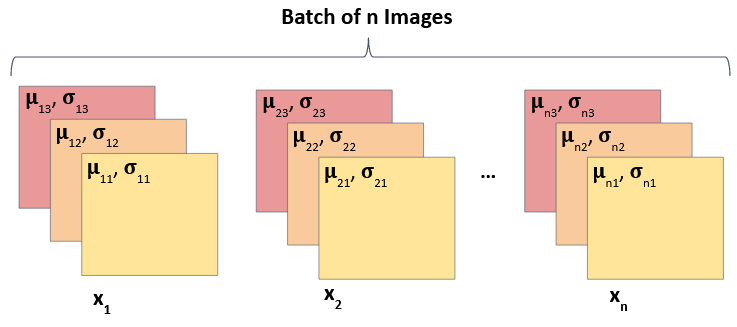

In [38]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### Downsampling

In [39]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

#### Upsampling

In [40]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

### U net Generator



In [41]:
def unet_generator():
    down_stack = [
        downsample(64, 4, True), # (bs, 64, 64, 64)
        downsample(64, 4),        # (bs, 32, 32, 64)
        downsample(128, 4),       # (bs, 16, 16, 128)
        downsample(128, 4),       # (bs, 8, 8, 128)
        downsample(256, 4),       # (bs, 4, 4, 256)
        downsample(256, 4),       # (bs, 2, 2, 256)
        downsample(512, 4)        # Bottleneck layer (bs, 1, 1, 512)
    ]
    up_stack = [
        upsample(256, 4, True),   # (bs, 2, 2, 256)
        upsample(256, 4),         # (bs, 4, 4, 256)
        upsample(128, 4),         # (bs, 8, 8, 128)
        upsample(128, 4),         # (bs, 16, 16,128)
        upsample(64, 4),          # (bs, 32, 32, 64)
        upsample(64, 4)           # (bs, 64, 64, 64)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 128, 128, 1)
    
    # Apply skip connections
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])
    x = inputs
    
    # Downsampling through the model
    skips = []                # List to store downsampling layers' latent information
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])       # Concat skip connections with Up-sampling layers
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [42]:
t1_generator = unet_generator()

t2_generator = unet_generator()

In [43]:
t1_generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 64)   1152        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 64)   65664       ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 16, 16, 128)  131328      ['sequential_1[0][0]']       

In [44]:
t2_generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_13 (Sequential)     (None, 64, 64, 64)   1152        ['input_2[0][0]']                
                                                                                                  
 sequential_14 (Sequential)     (None, 32, 32, 64)   65664       ['sequential_13[0][0]']          
                                                                                                  
 sequential_15 (Sequential)     (None, 16, 16, 128)  131328      ['sequential_14[0][0]']    

T1 Generator Model


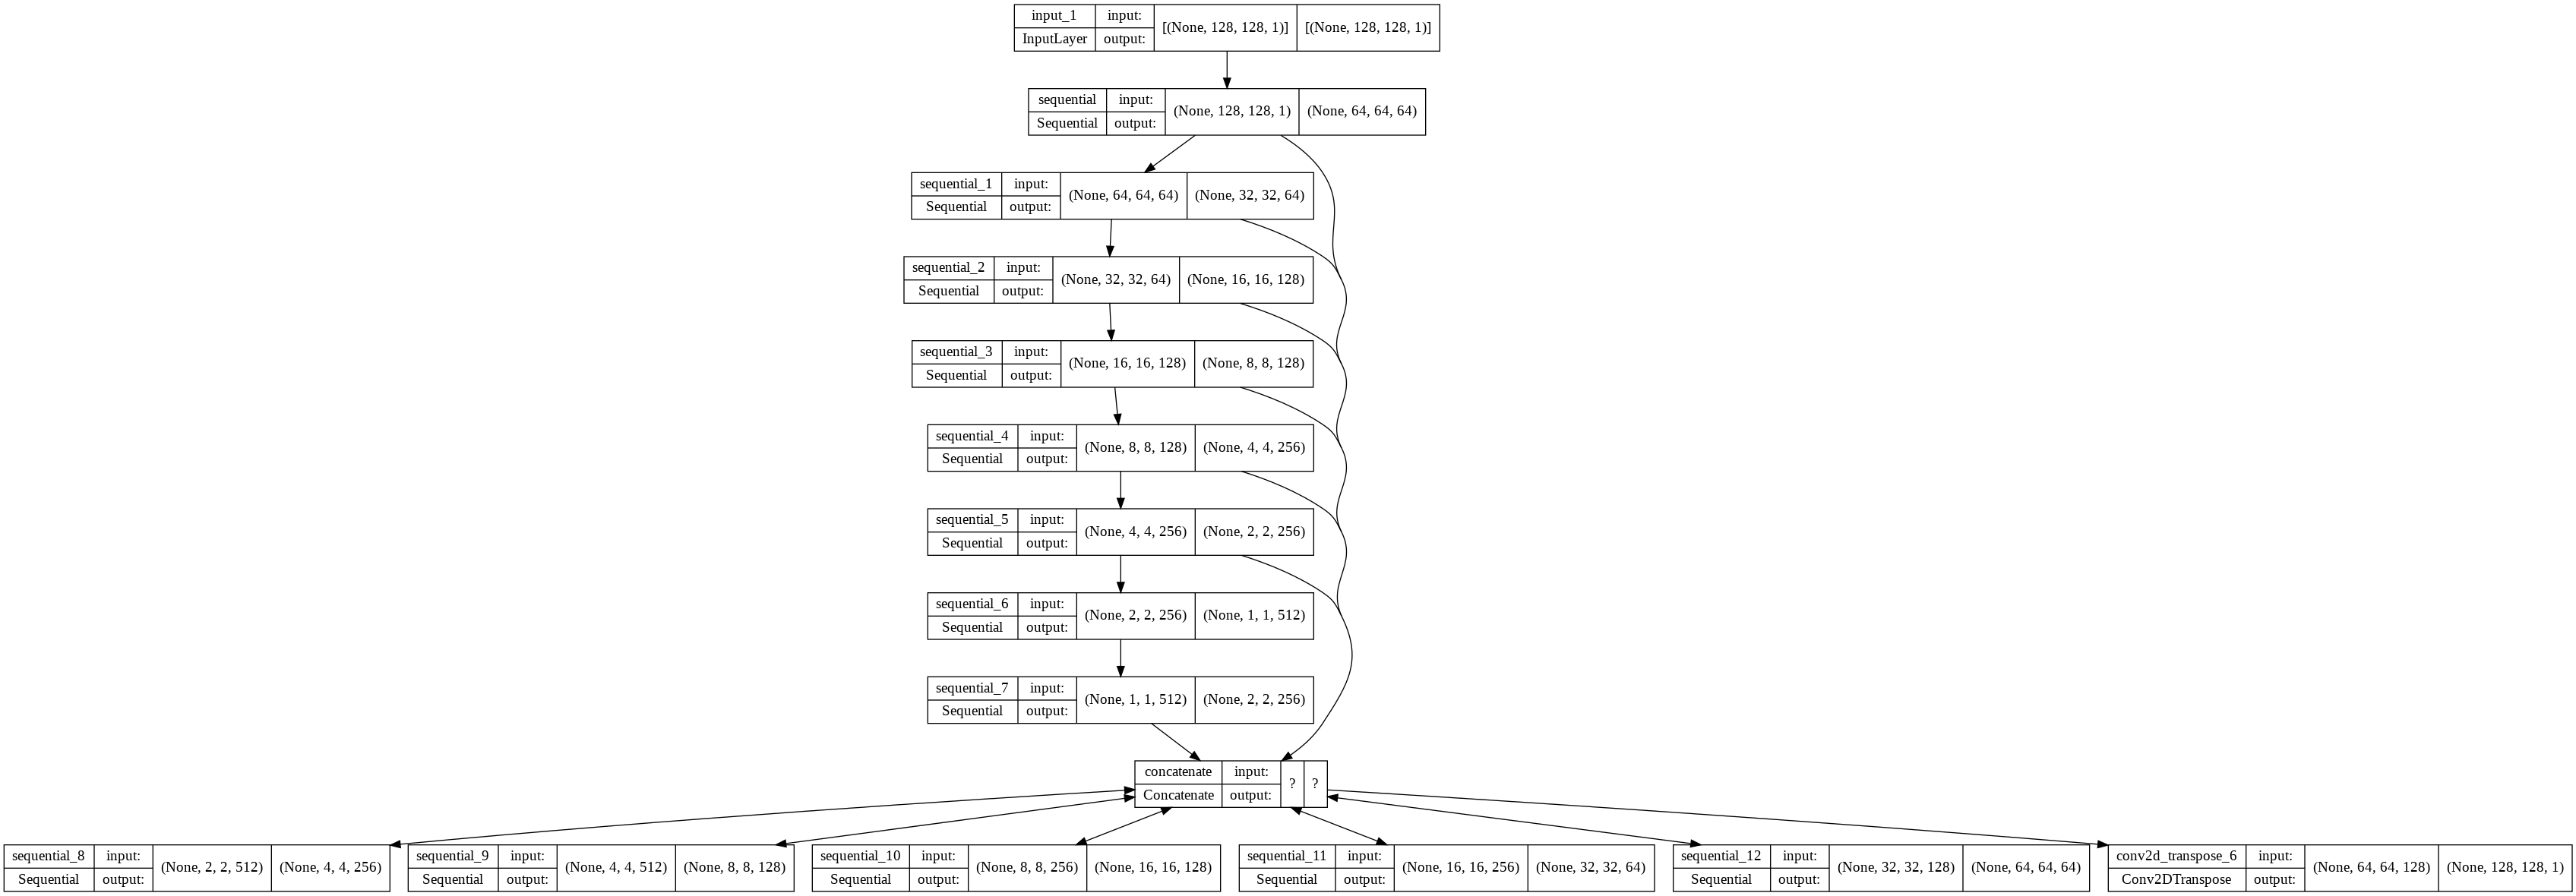

In [45]:
print('T1 Generator Model') 
plot_model(t1_generator,show_shapes = True,show_layer_names = True)

T2 Generator Model


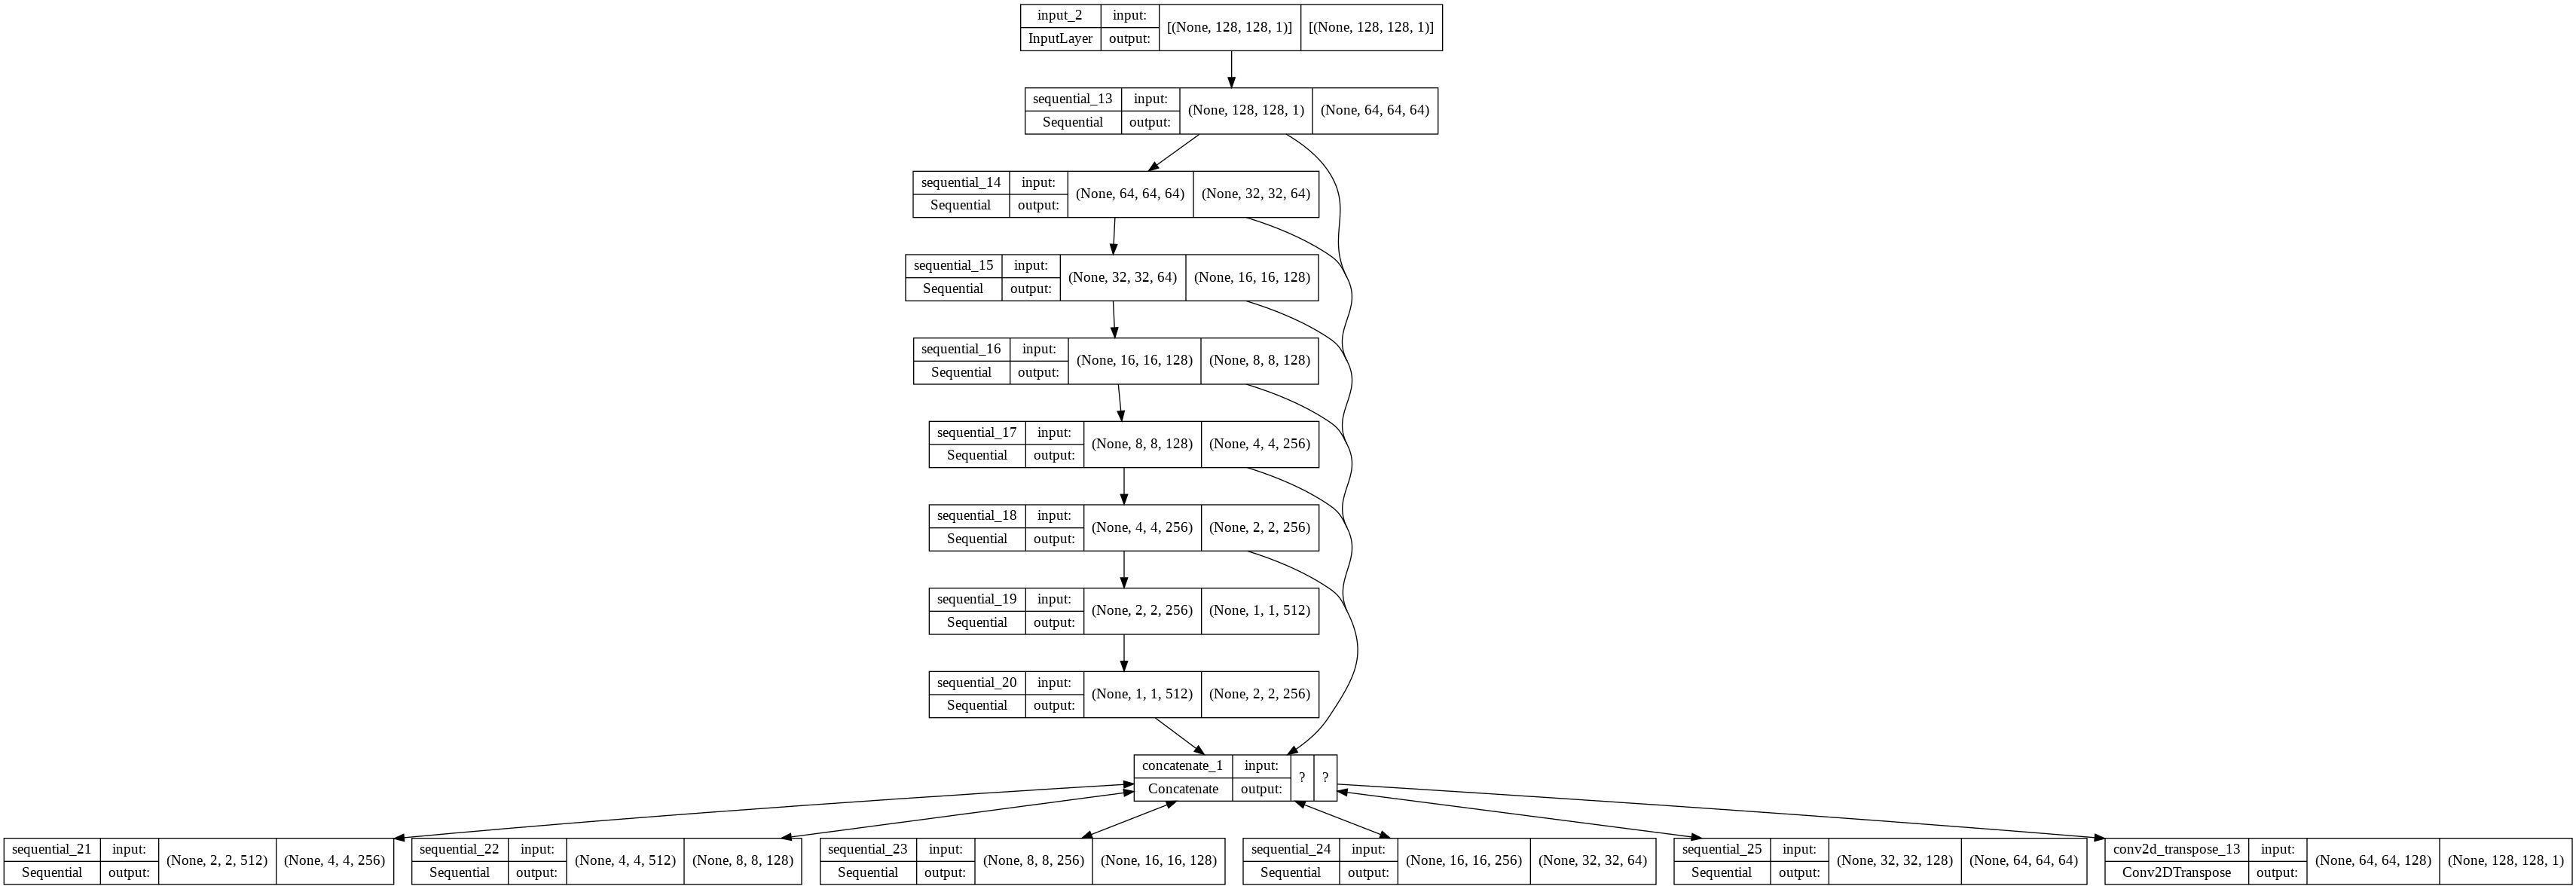

In [46]:
print('T2 Generator Model')
plot_model(t2_generator,show_shapes=True,show_layer_names=True)

### Discriminator

In [47]:
def discriminator():
  initializer = tf.random_normal_initializer(0.,0.02)
  inp = tf.keras.layers.Input(shape = [128,128,1],name='input_image')
  X = inp

  #downsampling
  down1 = downsample(64,4,False)(X)
  down2 = downsample(128,4)(down1)
  down3 = downsample(256,4)(down2)
  down4 = downsample(512,4)(down3)

  #zero-padding layer

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)

  # implement a concrete downsampling layer here

  conv = tf.keras.layers.Conv2D(256,4,strides = 1,kernel_initializer = initializer,
                                use_bias = False)(zero_pad1)
  
  norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  # adding another zero padding layer

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  # pure convolution layer

  last = tf.keras.layers.Conv2D(1,4,strides=1,kernel_initializer=initializer)(zero_pad2)

  return tf.keras.Model(inputs = inp,outputs = last)

In [48]:
# defining discriminator

# for T1 images
discriminator_t1 = discriminator()

# for T2 images

discriminator_t2 = discriminator()



In [49]:
# summary for T1 Discriminator

discriminator_t1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 sequential_26 (Sequential)  (None, 64, 64, 64)        1024      
                                                                 
 sequential_27 (Sequential)  (None, 32, 32, 128)       131328    
                                                                 
 sequential_28 (Sequential)  (None, 16, 16, 256)       524800    
                                                                 
 sequential_29 (Sequential)  (None, 8, 8, 512)         2098176   
                                                                 
 zero_padding2d (ZeroPadding  (None, 10, 10, 512)      0         
 2D)                                                             
                                                           

In [50]:
# summary for T2 Discriminator

discriminator_t2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 sequential_30 (Sequential)  (None, 64, 64, 64)        1024      
                                                                 
 sequential_31 (Sequential)  (None, 32, 32, 128)       131328    
                                                                 
 sequential_32 (Sequential)  (None, 16, 16, 256)       524800    
                                                                 
 sequential_33 (Sequential)  (None, 8, 8, 512)         2098176   
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 10, 10, 512)      0         
 ng2D)                                                           
                                                           

T1 Discriminator Model


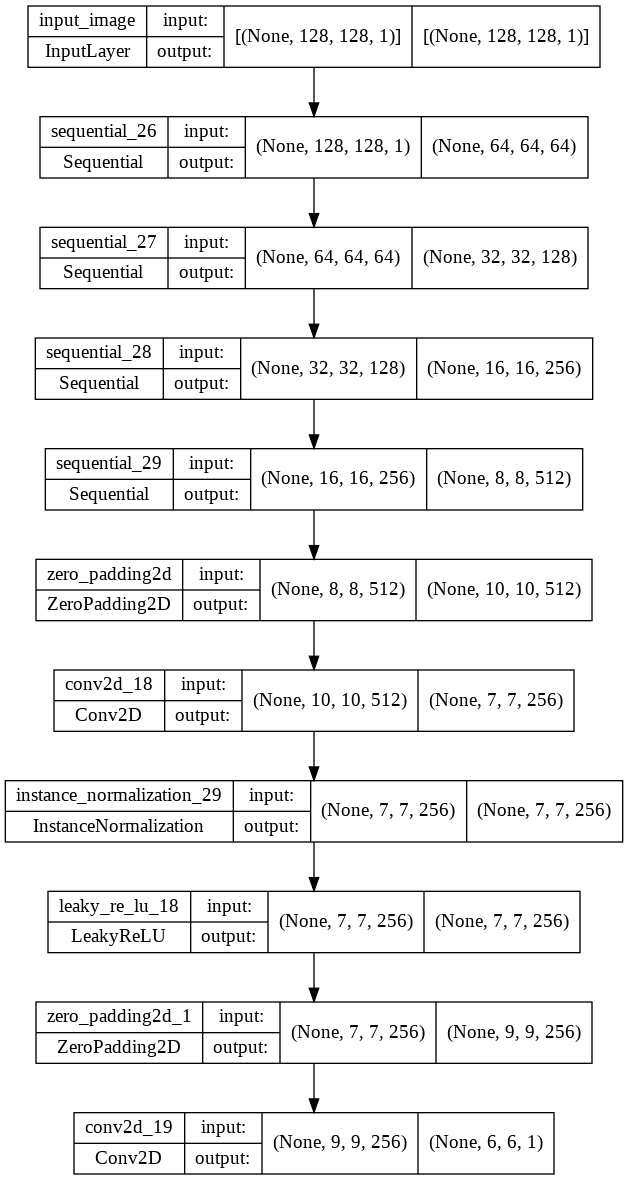

In [51]:
print('T1 Discriminator Model') 

plot_model(discriminator_t1,show_shapes = True,show_layer_names = True)

T2 Discriminator Model


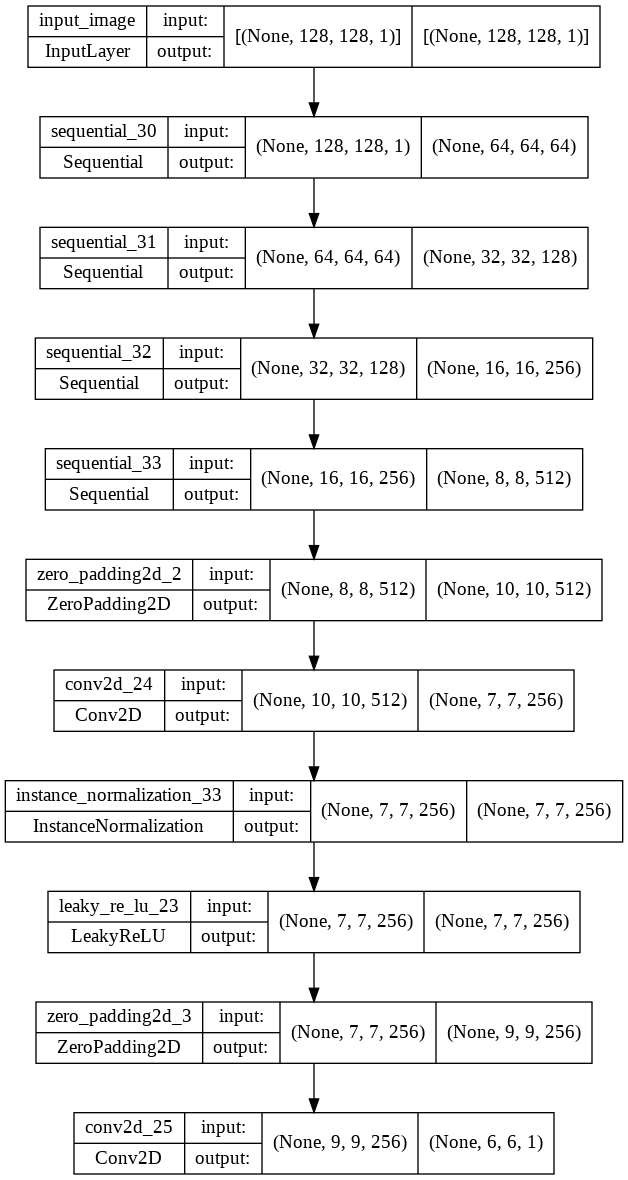

In [52]:
print('T2 Discriminator Model') 

plot_model(discriminator_t2,show_shapes = True,show_layer_names = True)

## Step 4 : Model Training

This are the below steps which will follow in Model Training :
1. Declare Loss type
2. Calculate Discriminator Loss
3. Calculate Generator Loss
4. Cycle Loss
5. Identity Loss
6. Optimizer
7. Checkpoint Initialization
8. Training Flow

### Checking Output of Untrained Generator

In [53]:
# checking sample

t1_sample = next(iter(t1_image_data))

t2_sample = next(iter(t2_image_data))


In [54]:
to_t2 = t2_generator(t1_sample)

to_t1 = t1_generator(t2_sample)

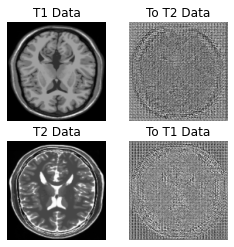

In [55]:
#plotting graph

plt.figure(figsize=(4,4))


mr1_image = [t1_sample,to_t2,t2_sample,to_t1]
mr1_title = ['T1 Data','To T2 Data','T2 Data','To T1 Data']

for i in range(len(mr1_image)):
    plt.subplot(2, 2, i+1)
    plt.title(mr1_title[i])
    plt.imshow(mr1_image[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

### Declaing Loss as Binary Cross Entropy



In [56]:
# Declaring loss object

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss


> There are 2 types of losses
1. Loss on Real Data 
2. Loss on Fake Data


In [57]:
def discriminator_loss(real,generated):
  real_loss = loss_obj(tf.ones_like(real),real)
  generated_loss = loss_obj(tf.zeros_like(generated),generated)

  # checking total discriminator loss
  total_disc_loss = real_loss + generated_loss

  #taking mean of losses
  return total_disc_loss * 0.5

### Generator Loss

> It has only one type of loss - Discriminator Loss on Generated data



In [58]:
def generator_loss(generated):
  gen_loss = loss_obj(tf.ones_like(generated),generated)
  return gen_loss

### Cyclic Loss

In [59]:
def cyclic_loss(real_image,cyclic_image):
  cyc_loss = tf.reduce_mean(tf.abs(real_image - cyclic_image))
  return 10.0 * cyc_loss

### Identity Loss

In [60]:
def identity_loss(real_image,same_image):
  id_loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return 2.0 * id_loss

### Optimizer

> We are using Optimizer to update Weights which is a good optimizer to achieve quick learning





In [61]:
#optimizer for generator

generator_t1_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1 = 0.5)

generator_t2_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1 = 0.5)

In [62]:
#optimizer for discriminator

discriminator_t1_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1 = 0.5)

discriminator_t2_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1 = 0.5)

### Checkpoint Initializer

In [63]:
if not os.path.isdir('training_checkpoints'):
    os.mkdir('training_checkpoints')

checkpoint_path = "./training_checkpoints"

ckpt = tf.train.Checkpoint(generator_T1=t1_generator,
                           generator_T2=t2_generator,
                           discriminator_T1=discriminator_t1,
                           discriminator_T2=discriminator_t2,
                           generator_T1_optimizer=generator_t1_optimizer,
                           generator_T2_optimizer=generator_t2_optimizer,
                           discriminator_T1_optimizer=discriminator_t1_optimizer,
                           discriminator_T2_optimizer=discriminator_t2_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

### Function to show Images output by Generators while Training

In [64]:
# Directory to keep Generated Images each epoch
if not os.path.isdir('generated_images'):
    os.mkdir('generated_images')

# Function to show Images output by Generators while Training
def generate_images(model1, test_input1, model2, test_input2, epoch):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(4, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input T1', 'Predicted T2 - Epoch ' + str(epoch), 'Input T2', 'Predicted T1 - Epoch ' + str(epoch)]
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('./generated_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Training Flow


This are below sequence of Training Flow

1.   Generate Fake Y and Cycled X
2.   Generate Fake X and Cycled Y
3.   Generate Fake Images through G and F for Identity Loss.
4.   Calculate Discriminator Loss for Disc X and Disc Y on Fake Data for Generator Training.
5.   Calculate Generator Loss on Discriminator.
6.   Calculate Cycled Loss on Cycled Images from step 1 and 2.
7.   Calculate Total Generator Loss - Disc Loss + Cycled Loss + Identity Loss
8.   Calculate Discriminator Loss on both Fake and Real Images for Disc X and Y for Disc Training.
9.   Calculate the Gradients and update the weight and bias of models.



In [65]:
@tf.function

def train_step(real_t1,real_t2):
  with tf.GradientTape(persistent=True) as tape:

    #generator g translates t1 --> t2
    #generator f translates t2 --> t1
    fake_t2 = t2_generator(real_t1,training=True)
    cycled_t1 = t1_generator(fake_t2,training = True)

    fake_t1 = t1_generator(real_t2,training=True)
    cycled_t2 = t2_generator(fake_t1,training = True)

    #same_t1 and same_t2 used for identity loss

    same_t1 = t1_generator(real_t1,training=True)
    same_t2 = t2_generator(real_t2,training = True)

    # Real Discriminator for T1 and T2
    disc_real_t1 = discriminator_t1(real_t1,training = True)
    disc_real_t2 = discriminator_t2(real_t2,training = True)

    # Fake Discriminator for T1 and T2
    disc_fake_t1 = discriminator_t1(fake_t1,training = True)
    disc_fake_t2 = discriminator_t2(fake_t2,training = True)

    # calculating the loss
    gen_t1_loss = generator_loss(disc_fake_t1)

    gen_t2_loss = generator_loss(disc_fake_t2)

    # calculating identity loss
  
    ide_t1_loss = identity_loss(real_t1,same_t1)

    ide_t2_loss = identity_loss(real_t2,same_t2)
    

    # calculating total cyclic loss

    total_cyclic_loss = cyclic_loss(real_t1,cycled_t1) + cyclic_loss(real_t2,cycled_t2)

    # calculating total Generator Loss

    total_gen_t1_loss = gen_t1_loss + total_cyclic_loss + ide_t1_loss
    total_gen_t2_loss = gen_t2_loss + total_cyclic_loss + ide_t2_loss

    # calculating disctiminator loss

    disc_t1_loss = discriminator_loss(disc_real_t1,disc_fake_t1)
    disc_t2_loss = discriminator_loss(disc_real_t2,disc_fake_t2)

  # Calculating the gradients for generator and discriminator

  generator_t1_gradients = tape.gradient(total_gen_t1_loss,t1_generator.trainable_variables)
  generator_t2_gradients = tape.gradient(total_gen_t2_loss,t2_generator.trainable_variables)

  discriminator_t1_gradients = tape.gradient(disc_t1_loss,discriminator_t1.trainable_variables)
  discriminator_t2_gradients = tape.gradient(disc_t2_loss,discriminator_t2.trainable_variables)

  # Applying Gradient to the Optimizers

  generator_t1_optimizer.apply_gradients(zip(generator_t1_gradients,t1_generator.trainable_variables))
  generator_t2_optimizer.apply_gradients(zip(generator_t2_gradients,t2_generator.trainable_variables))


  discriminator_t1_optimizer.apply_gradients(zip(discriminator_t1_gradients,discriminator_t1.trainable_variables))
  discriminator_t2_optimizer.apply_gradients(zip(discriminator_t2_gradients,discriminator_t2.trainable_variables))


In [66]:
for img_t1 in t1_image_data:
  for img_t2 in t2_image_data:
    print("Shape of T1 Image : ",img_t1.shape," Shape of T2 Image : ",img_t2.shape)

Shape of T1 Image :  (43, 128, 128, 1)  Shape of T2 Image :  (46, 128, 128, 1)


In [67]:
#declare epoch

EPOCHS = 30

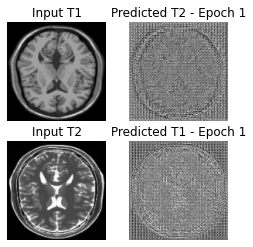

Saving checkpoint for epoch 1 at ./training_checkpoints/ckpt-1


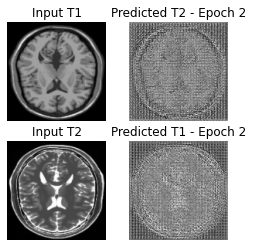

Saving checkpoint for epoch 2 at ./training_checkpoints/ckpt-2


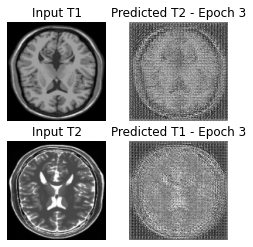

Saving checkpoint for epoch 3 at ./training_checkpoints/ckpt-3


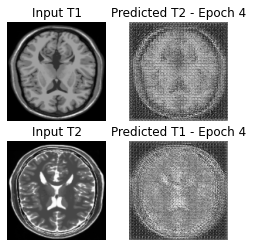

Saving checkpoint for epoch 4 at ./training_checkpoints/ckpt-4


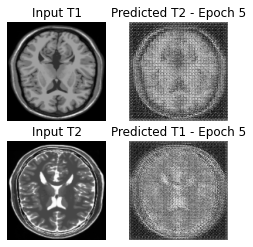

Saving checkpoint for epoch 5 at ./training_checkpoints/ckpt-5


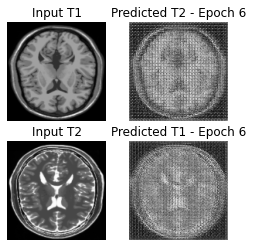

Saving checkpoint for epoch 6 at ./training_checkpoints/ckpt-6


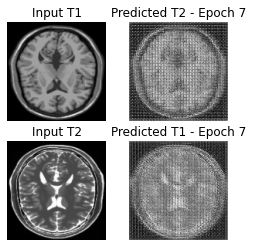

Saving checkpoint for epoch 7 at ./training_checkpoints/ckpt-7


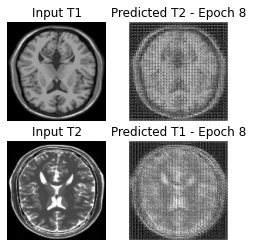

Saving checkpoint for epoch 8 at ./training_checkpoints/ckpt-8


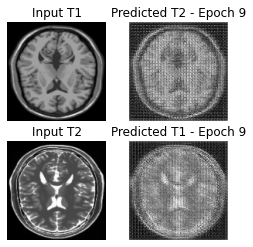

Saving checkpoint for epoch 9 at ./training_checkpoints/ckpt-9


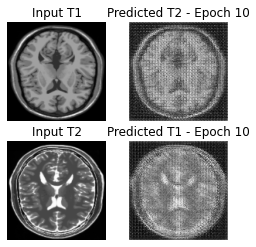

Saving checkpoint for epoch 10 at ./training_checkpoints/ckpt-10


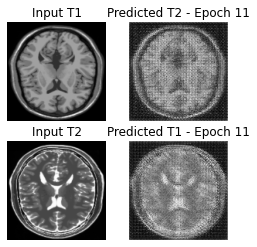

Saving checkpoint for epoch 11 at ./training_checkpoints/ckpt-11


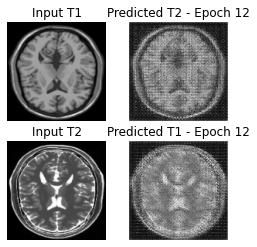

Saving checkpoint for epoch 12 at ./training_checkpoints/ckpt-12


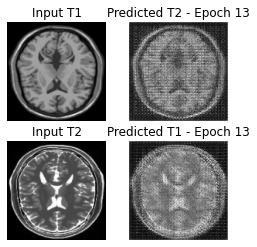

Saving checkpoint for epoch 13 at ./training_checkpoints/ckpt-13


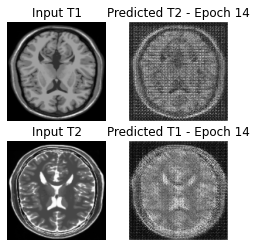

Saving checkpoint for epoch 14 at ./training_checkpoints/ckpt-14


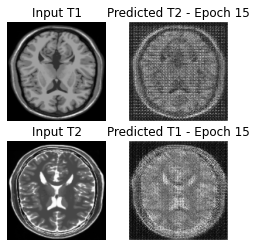

Saving checkpoint for epoch 15 at ./training_checkpoints/ckpt-15


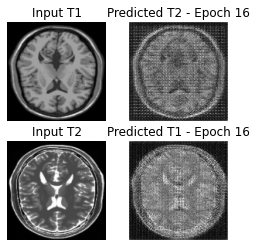

Saving checkpoint for epoch 16 at ./training_checkpoints/ckpt-16


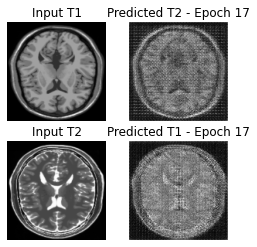

Saving checkpoint for epoch 17 at ./training_checkpoints/ckpt-17


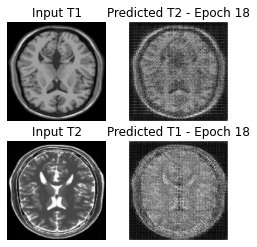

Saving checkpoint for epoch 18 at ./training_checkpoints/ckpt-18


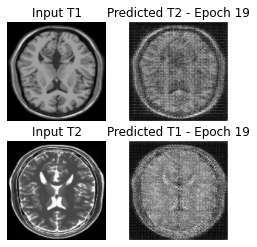

Saving checkpoint for epoch 19 at ./training_checkpoints/ckpt-19


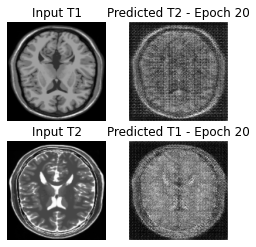

Saving checkpoint for epoch 20 at ./training_checkpoints/ckpt-20


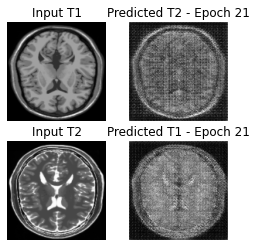

Saving checkpoint for epoch 21 at ./training_checkpoints/ckpt-21


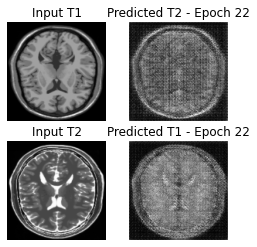

Saving checkpoint for epoch 22 at ./training_checkpoints/ckpt-22


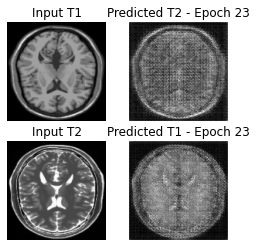

Saving checkpoint for epoch 23 at ./training_checkpoints/ckpt-23


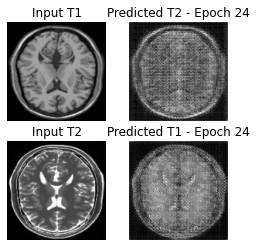

Saving checkpoint for epoch 24 at ./training_checkpoints/ckpt-24


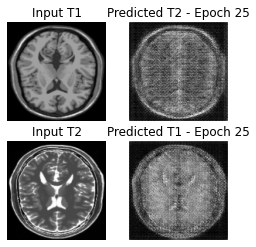

Saving checkpoint for epoch 25 at ./training_checkpoints/ckpt-25


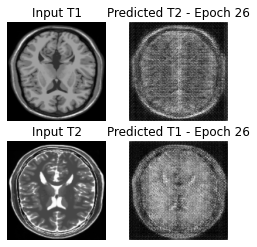

Saving checkpoint for epoch 26 at ./training_checkpoints/ckpt-26


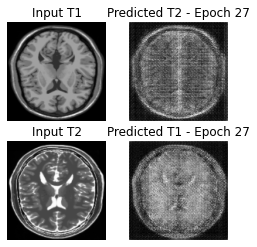

Saving checkpoint for epoch 27 at ./training_checkpoints/ckpt-27


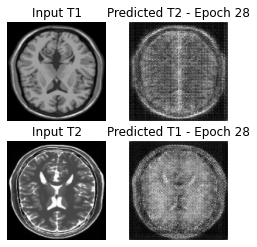

Saving checkpoint for epoch 28 at ./training_checkpoints/ckpt-28


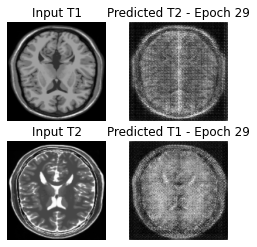

Saving checkpoint for epoch 29 at ./training_checkpoints/ckpt-29


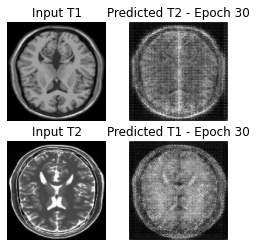

Saving checkpoint for epoch 30 at ./training_checkpoints/ckpt-30


In [68]:
for epoch in range(1, EPOCHS+1):
  for img_x in t1_image_data:
    for img_y in t2_image_data:
      train_step(img_x,img_y)
  generate_images(t2_generator,t1_sample,t1_generator,t2_sample,epoch)
  ckpt_save_path = ckpt_manager.save()

  print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)



In [69]:
anim_file = 'MRI_T1_T2_version.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./generated_images/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [70]:
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-etuj9x2p
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-etuj9x2p
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=6802c97d29e3cd3720409cc86534156d3764f5093273d9e907f0cfd333dd0997
  Stored in directory: /tmp/pip-ephem-wheel-cache-9w04x1e5/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs



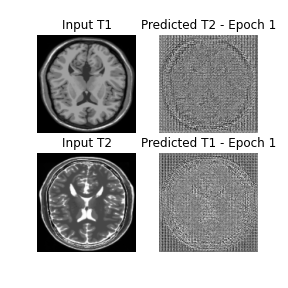

In [71]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)